In [1]:
import os
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr

In [2]:
parent = os.path.join(Path(os.getcwd()).parent)

print(parent)

sys.path.append(parent)

c:\Users\bruij_kn\OneDrive - Stichting Deltares\Documents\GitHub\thermo-morphological-model


In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

In [5]:
# reference variables
per_sa = {
    "start_time": pd.to_datetime("2018-01-01"), # these dates are relevant for the bluff edge only
    "end_time": pd.to_datetime("2019-01-01"),
}

I need:
- I need to extract total erosion of each variable, and check against baseline
- A way to differentiate between different types of tested variables

==> pd.DataFrame with columns for runid, sensitivity analysis level, sublevel, total erosion, and total erosion over baseline erosion.

In [3]:
# load overview dataframe
fpath_overview = Path("overview_sa.csv")
df = pd.read_csv(fpath_overview)

# get values for base run
fpath_base = Path("erosion_rates/sa_base.csv")
df_base = pd.read_csv(fpath_base, parse_dates=['time'])

x_start_base = df_base['x_bluff_edge'].values[0]
x_end_base = df_base['x_bluff_edge'].values[-1]
total_bluff_erosion_base = x_end_base - x_start_base

# initialize erosion
total_erosion = []
rnte = [] # relative normalized total erosion

# loop through all parameters
for i, row in df.iterrows():
    runid_low = row['run_id_low']
    runid_high = row['run_id_high']
    
    df_low = pd.read_csv(Path(f'erosion_rates/{runid_low}.csv'), parse_dates=['time'])
    df_high = pd.read_csv(Path(f'erosion_rates/{runid_high}.csv'), parse_dates=['time'])

    x_start_low = df_low['x_bluff_edge'].values[0]
    x_start_high = df_high['x_bluff_edge'].values[0]
    
    x_end_low = df_low['x_bluff_edge'].values[-1]
    x_end_high = df_high['x_bluff_edge'].values[-1]
    
    total_erosion_low = x_end_low - x_start_low
    total_erosion_high = x_end_high - x_start_high
    
    rnte_low = total_erosion_low / total_bluff_erosion_base
    rnte_high = total_erosion_high / total_bluff_erosion_base
    
    total_erosion.append(total_erosion_low, total_erosion_high)
    rnte.append(rnte_low, rnte_high)
    
# add new columns
total_erosion = np.array(total_erosion)
rnte = np.array(rnte)

df['total_erosion_low[m]'] = total_erosion[0,:]
df['total_erosion_high[m]'] = total_erosion[1,:]

df['rnte_low[-]'] = rnte[0,:]
df['rnte_high[-]'] = rnte[1,:]

# order dataframe from low to high
order_mask = np.argsort(np.abs(df['total_erosion_high[m]'].values - df['total_erosion_low[m]'].values))
df = df[order_mask]

NameError: name 'Path' is not defined

We can make a tornado plot out of this!

NameError: name 'df' is not defined

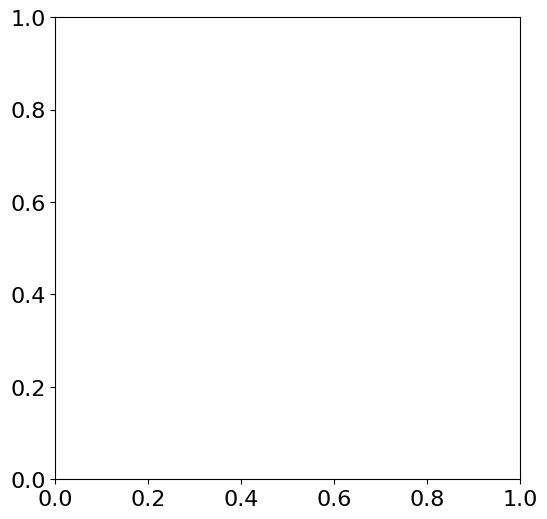

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

x_left = total_bluff_erosion_base

ax.barh(np.arange(len(df)), width=df['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
ax.barh(np.arange(len(df)), width=df['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

ax.axvline(x_left, color='k', label='Base erosion')

ax.set_xticks(np.arange(len(df)), df['run_id'].values)

ax.grid()

ax.set_title('Total erosion when varying model parameters one at a time')

ax.legend()

ax.set_xlabel('Total bluff erosion [m]')
ax.set_ylabel('run ID [-]')

fig.tight_layout()

# figname = 'RMSE_integrated_model.png'

# fig.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(6, 6))

df_bathy = df[df['sublevel']=='bathymetry']
df_model = df[df['sublevel']=='model']
df_physi = df[df['sublevel']=='physical']
df_envir = df[(df['sublevel']=='hydrodynamics') or df['sublevel']=='thermodynamics']
# df_therm = df[df['sublevel']=='thermodynamics']

x_left = total_bluff_erosion_base

axs[0, 0].barh(np.arange(len(df_bathy)), width=df_bathy['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
axs[0, 0].barh(np.arange(len(df_bathy)), width=df_bathy['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

axs[0, 1].barh(np.arange(len(df_model)), width=df_model['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
axs[0, 1].barh(np.arange(len(df_model)), width=df_model['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

axs[1, 0].barh(np.arange(len(df_physi)), width=df_physi['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
axs[1, 0].barh(np.arange(len(df_physi)), width=df_physi['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

axs[1, 1].barh(np.arange(len(df_envir)), width=df_envir['total_erosion_low[m]'].values, left=x_left, label='Low', color='b')
axs[1, 1].barh(np.arange(len(df_envir)), width=df_envir['total_erosion_high[m]'].values, left=x_left, label='High', color='r')

# axs[1, 1].barh(np.arange(len(df_therm)), width=df_therm['total_erosion_low[m]'].values, left=x_left, label='thermo Low', color='y')
# axs[1, 1].barh(np.arange(len(df_therm)), width=df_therm['total_erosion_high[m]'].values, left=x_left, label='thermo High', color='g')

for ax1, ax2 in axs:
    for ax in (ax1, ax2):
        ax.axvline(x_left, color='k', label='base erosion')

        ax.grid()

        ax.legend()

        ax.set_xlabel('Total bluff erosion [m]')
        ax.set_ylabel('run ID [-]')

axs[0, 0].set_title('Bathymetry parameters')
axs[0, 1].set_title('Model parameters')
axs[1, 0].set_title('Physical parameters')
axs[1, 1].set_title('Environmental drivers')

axs[0, 0].set_xticks(np.arange(len(df_bathy)), df_bathy['run_id'].values)
axs[0, 1].set_xticks(np.arange(len(df_model)), df_bathy['run_id'].values)
axs[1, 0].set_xticks(np.arange(len(df_physi)), df_bathy['run_id'].values)
axs[1, 1].set_xticks(np.arange(len(df_envir)), df_bathy['run_id'].values)


fig.tight_layout()

# figname = 'RMSE_integrated_model.png'

# fig.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)